# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

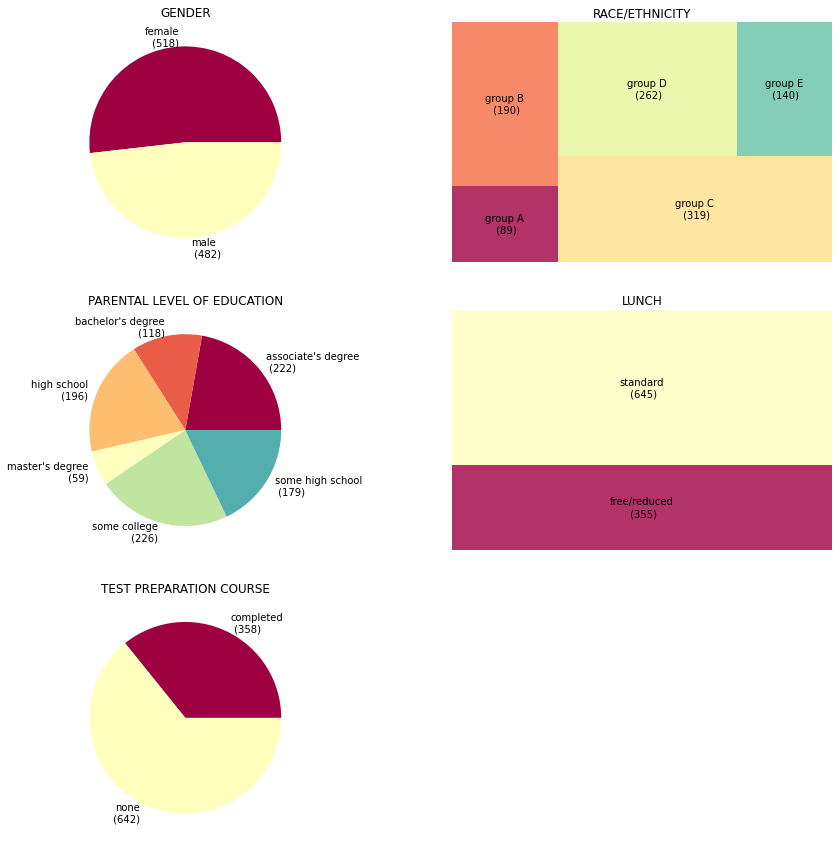

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Numeričke značajke 

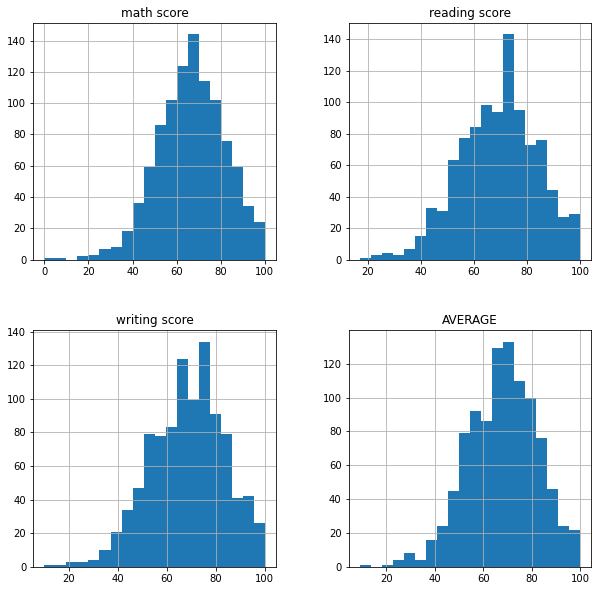

In [6]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

## Usporedba spola

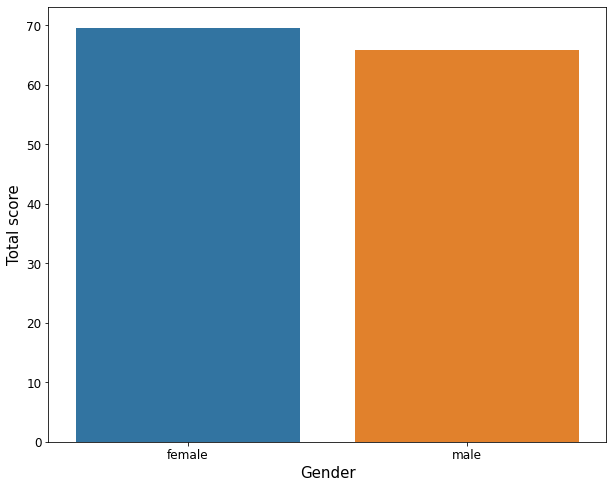

In [7]:
df['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
plt.figure(figsize = (10,8))
sns.barplot(data = df, x = 'gender', y = 'Total score', ci = False)
plt.xticks(fontsize = 12)
plt.xlabel('Gender', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Total score', fontsize = 15)
plt.show()

 
    

## Utjecaj priprema za ispit na rezultate 

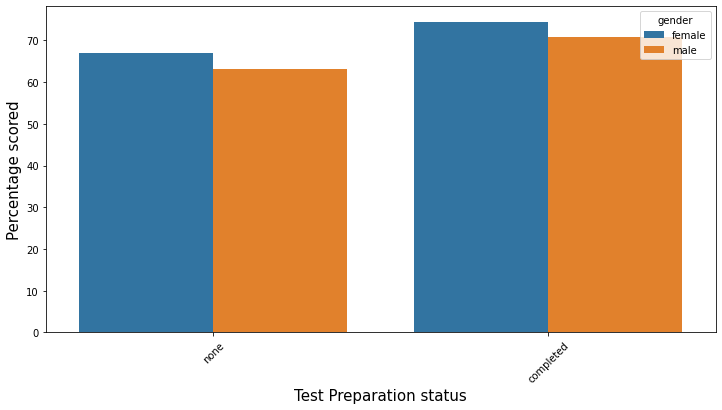

In [8]:
plt.figure(figsize = (12,6))
sns.barplot(data = df, x = 'test preparation course', y = 'Total score', hue = 'gender', ci = False)
plt.xlabel('Test Preparation status', fontsize = 15)
plt.xticks(rotation = 45)
plt.ylabel('Percentage scored', fontsize = 15)
plt.show()

df = df.drop(["Total score"],axis = 'columns')

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [9]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [10]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    #target= table["AVERAGE"]
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [11]:
def odaberi(algorithm,k,train_X, train_y,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(train_X, train_y)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(train_X.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, train_X.shape[1]])
    plt.xticks(range(train_X.shape[1]), train_X.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : ONE HOT ENCODING

In [12]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [13]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')


### Rezultat s metodom: f_regression

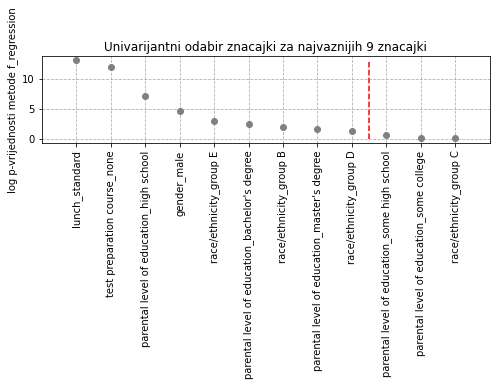

In [14]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

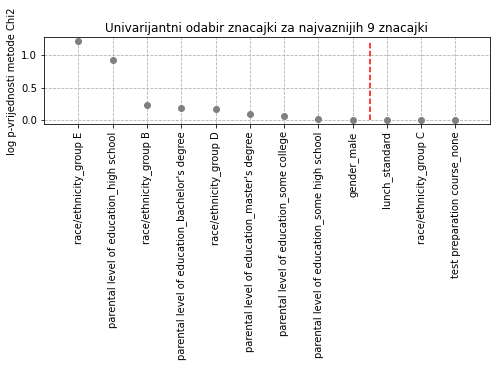

In [15]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

### 2.Odabir encodinga za feature selection : LABEL


In [16]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [17]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')

### Rezultat s metodom: f_regression

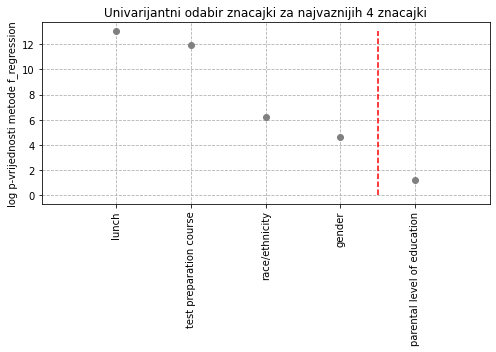

In [18]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

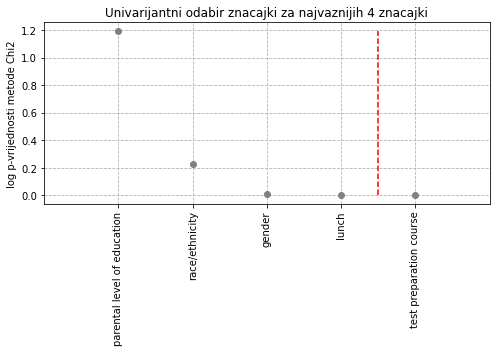

In [19]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [20]:
def residual(true,pred):
    resid = true - pred
    print( np.sqrt(np.mean(resid*resid)) )
def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

In [21]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

train_X, valid_X, train_y, valid_y = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

#train_y_N=train_y_N.astype('int')

In [22]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [23]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [25]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

[[68.82978317 75.65367333 76.5264202  73.66978715]
 [61.43791046 69.04538718 67.23868091 65.90742088]
 [66.30005673 74.02577652 73.11160368 71.14560804]
 [58.2807336  65.64444182 61.96171883 61.96162227]
 [58.0741935  68.84461755 68.50461688 65.14102779]
 [60.89387957 68.41617614 66.14530088 65.1520576 ]
 [69.21019237 77.51525849 80.38918371 75.7051096 ]
 [66.30005673 74.02577652 73.11160368 71.14560804]
 [57.41327047 56.37489472 52.27488543 55.3539309 ]
 [70.67301671 65.42182192 62.84436233 66.31268573]
 [74.07233864 82.49564782 86.26210649 80.94329677]
 [53.21204723 63.86422822 62.6316941  59.90284062]
 [73.66028047 69.91636484 70.83603189 71.47101446]
 [70.12898581 64.79261088 61.7509823  65.55732246]
 [62.72509488 75.88538918 78.00114437 72.20422277]
 [65.15998252 65.45474064 64.55824529 65.05743598]
 [53.4207197  66.84043447 66.4048903  62.22217566]
 [67.11399007 63.86108788 61.47986104 64.15155805]
 [69.03845563 78.62987958 80.29961639 75.9891222 ]
 [69.2771121  64.10082514 61.76

In [26]:
def lin_reg(X,y):
    LinearReg = LinearRegression(normalize = True)
    LinearReg = LinearReg.fit(X,y)

    return LinearReg


In [27]:
model_LINEAR = lin_reg(train_X,train_y)

predicted_valid_y = model_LINEAR.predict(valid_X)

In [28]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

12.173729915781685
Test set
MSE: 148.19970006239797
MAE: 9.725579943586775
RMSE: 12.173729915781685
R-squared: 0.28018917141684585 , from <0,1> 


### MultitaskLasso Regresija (3 izlaza)

In [29]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [30]:
train_X_lasso, valid_X_lasso, train_y_lasso, valid_y_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [31]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(train_X_lasso,train_y_lasso)

pred=MTL.predict(valid_X_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(valid_X_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [32]:
residual(valid_y_lasso, pred)

print("\nScores:")
evaluateRegressor(valid_y_lasso, pred)

math score       13.860696
reading score    12.818428
writing score    12.563250
dtype: float64

Scores:
Test set
MSE: 171.4220845033959
MAE: 10.427402013978332
RMSE: 13.080791496714767
R-squared: 0.256177633475969 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.31
R2 = 0.30
MSE = 147.49


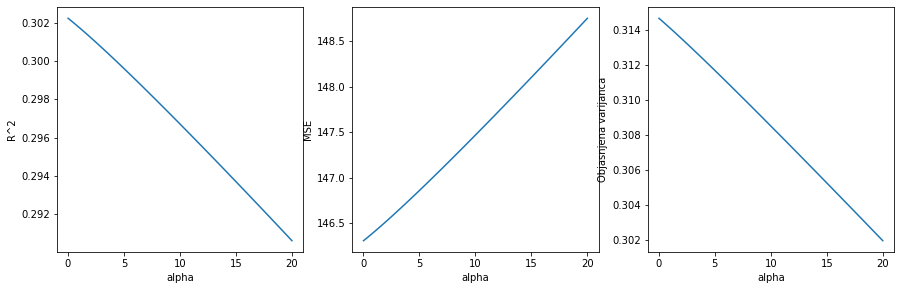

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))
ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## XGBoost

## LightGBM

In [34]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)

predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

    Training Set
MSE: 137.64572706425244
MAE: 9.370538765975732
RMSE: 11.732251576924714
R-squared: 0.3197861707087939 , from <0,1> 
    Test Set
MSE: 157.60183185692952
MAE: 10.030038841736843
RMSE: 12.55395682073702
R-squared: 0.23452270735099223 , from <0,1> 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

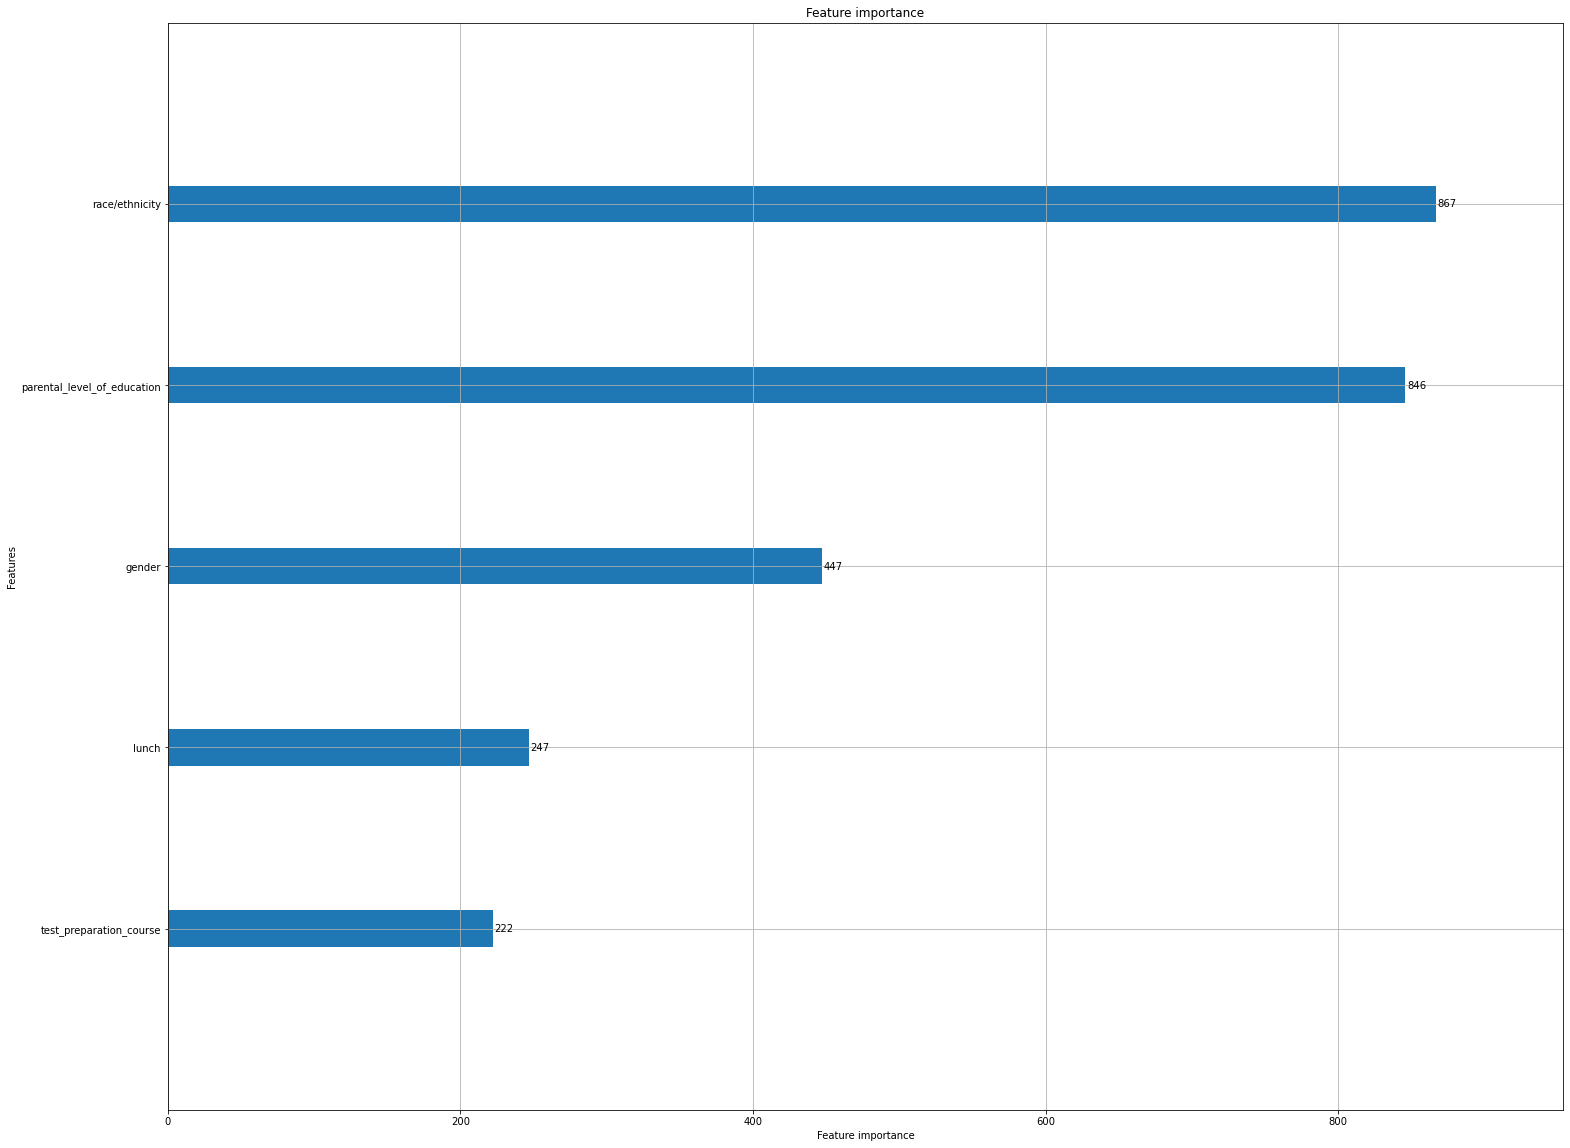

In [35]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

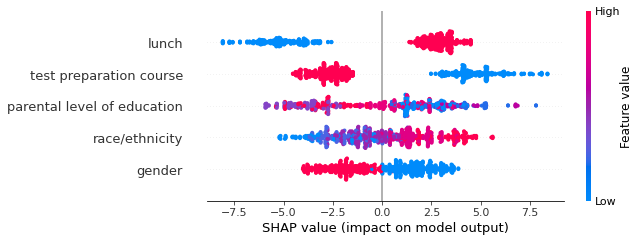

In [36]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

## CATBoost

In [37]:
from catboost import CatBoostRegressor
# Initialize data

train_data = train_X

eval_data = valid_X

train_labels = train_y

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=200,
                          learning_rate=1,
                          depth=2)
# Fit model
model.fit(train_data, train_labels)


0:	learn: 13.2088081	total: 49.9ms	remaining: 9.93s
1:	learn: 13.0730983	total: 50.9ms	remaining: 5.04s
2:	learn: 12.7550367	total: 51.6ms	remaining: 3.39s
3:	learn: 12.7168657	total: 52.4ms	remaining: 2.57s
4:	learn: 12.6512263	total: 53.2ms	remaining: 2.07s
5:	learn: 12.6367633	total: 53.8ms	remaining: 1.74s
6:	learn: 12.6070540	total: 54.5ms	remaining: 1.5s
7:	learn: 12.5905330	total: 55.2ms	remaining: 1.32s
8:	learn: 12.5835374	total: 56ms	remaining: 1.19s
9:	learn: 12.5734185	total: 56.8ms	remaining: 1.08s
10:	learn: 12.5617222	total: 57.6ms	remaining: 990ms
11:	learn: 12.5455422	total: 58.3ms	remaining: 913ms
12:	learn: 12.5379597	total: 59ms	remaining: 848ms
13:	learn: 12.5303680	total: 59.7ms	remaining: 793ms
14:	learn: 12.5244373	total: 60.3ms	remaining: 744ms
15:	learn: 12.5225976	total: 61.1ms	remaining: 702ms
16:	learn: 12.5155032	total: 61.8ms	remaining: 665ms
17:	learn: 12.5133405	total: 62.4ms	remaining: 631ms
18:	learn: 12.5104069	total: 63.1ms	remaining: 601ms
19:	lear

In [38]:
# Get predictions
pred_train= model.predict(train_data)
pred = model.predict(eval_data)

In [39]:
residual(valid_y, pred)

print("\nScores:")
evaluateRegressor(train_y, pred_train)
evaluateRegressor(valid_y, pred)

12.201670629835073

Scores:
Test set
MSE: 151.84207703449752
MAE: 9.851195477728904
RMSE: 12.322421719552432
R-squared: 0.24963104289497606 , from <0,1> 
Test set
MSE: 148.8807661589799
MAE: 9.798469509213694
RMSE: 12.201670629835077
R-squared: 0.27688121093450935 , from <0,1> 


## ANN

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Importing necessary models for implementation of ANN



model = Sequential()
model.add(Dense(100, input_dim=train_X.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(train_X, train_y, epochs=10)

Epoch 1/10
25/25 [==============================] - 0s 748us/step - loss: 4791.2505 - mse: 4791.2505
Epoch 2/10
25/25 [==============================] - 0s 636us/step - loss: 4761.9927 - mse: 4761.9927
Epoch 3/10
25/25 [==============================] - 0s 682us/step - loss: 4706.2314 - mse: 4706.2314
Epoch 4/10
25/25 [==============================] - 0s 673us/step - loss: 4614.1074 - mse: 4614.1074
Epoch 5/10
25/25 [==============================] - 0s 690us/step - loss: 4481.3892 - mse: 4481.3892
Epoch 6/10
25/25 [==============================] - 0s 762us/step - loss: 4307.8892 - mse: 4307.8892
Epoch 7/10
25/25 [==============================] - 0s 667us/step - loss: 4095.7122 - mse: 4095.7122
Epoch 8/10
25/25 [==============================] - 0s 659us/step - loss: 3845.1985 - mse: 3845.1985
Epoch 9/10
25/25 [==============================] - 0s 669us/step - loss: 3556.4219 - mse: 3556.4219
Epoch 10/10
25/25 [==============================] - 0s 634us/step - loss: 3237.1348 - mse:

In [42]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
#model = load_model('cnn_model.h5')

predicted_valid_y = model.predict(valid_X)
predicted_valid_y = pd.Series([i[0] for i in predicted_valid_y])

In [43]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

55.85805384144501
Test set
MSE: 3049.504034898524
MAE: 53.3235610850652
RMSE: 55.22231464633227
R-squared: -13.811541623928848 , from <0,1> 


## Slučajne šume

In [44]:
from sklearn.ensemble import RandomForestRegressor

# Creating Random Forest Model
rf = RandomForestRegressor(n_estimators=400)

# Training Model
rf.fit(train_X , train_y)

RandomForestRegressor(n_estimators=400)

In [45]:
# Predictions
predictions = rf.predict(valid_X)

In [46]:
residual(valid_y, predictions)
evaluateRegressor(valid_y, predictions)

13.338086174261672
Test set
MSE: 177.90454279203027
MAE: 10.439747508369027
RMSE: 13.338086174261669
R-squared: 0.1359117710634964 , from <0,1> 


## SVM

In [47]:
SVM = svm.SVR().fit(train_X, train_y) 

In [48]:
predicted_train_y = SVM.predict(train_X)                           #<----SVM -- Support Vector Machine
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = SVM.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

    Training Set
MSE: 171.80606176871777
MAE: 10.350196062160261
RMSE: 13.107481137454204
R-squared: 0.15097357786784782 , from <0,1> 
    Test Set
MSE: 167.5987303747367
MAE: 10.30968181798135
RMSE: 12.945992830785004
R-squared: 0.18596744170379642 , from <0,1> 


In [49]:
from sklearn.svm import SVR
def SV_reg(kernel,train_X, train_Y):
    model=SVR(kernel)
    model.fit(train_X, train_Y)
    return model


SVM_model= SV_reg("linear",train_X, train_y)
pred_linear = SVM_model.predict(valid_X)
linear_rmse = np.sqrt(mean_squared_error(valid_y,pred_linear))

SVM_model= SV_reg("poly",train_X, train_y)
pred_poly = SVM_model.predict(valid_X)
poly_rmse = np.sqrt(mean_squared_error(valid_y,pred_poly))

SVM_model= SV_reg("sigmoid",train_X, train_y)
pred_sigmoid = SVM_model.predict(valid_X)
sigmoid_rmse = np.sqrt(mean_squared_error(valid_y,pred_sigmoid))

SVM_model= SV_reg("rbf",train_X, train_y)
pred_rbf = SVM_model.predict(valid_X)
rbf_rmse = np.sqrt(mean_squared_error(valid_y,pred_rbf))



data = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse]),
            "Pred":pd.Series([pred_linear,pred_poly,pred_sigmoid,pred_rbf])}
table_rmse=pd.DataFrame(data)
table_rmse

,kernel,Test RMSE,Pred
0,linear,12.393679,"[66.82639523031428, 66.56118988034255, 66.5611..."
1,polynomial,12.711369,"[67.04393511711818, 67.9078918540634, 67.90789..."
2,sigmoid,23.385853,"[80.37945232594635, 88.21915936949976, 88.2191..."
3,rbf,12.945993,"[67.15213689412255, 68.90016975421587, 68.9001..."


Grid search

In [50]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
parameters = [{'kernel': ['linear','sigmoid','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

svr_gs.fit(train_X, train_y)
print(svr_gs.best_params_)

{'C': 4, 'gamma': 0.02, 'kernel': 'linear'}


ONCE WE GET BEST RESULTS , WE ONCE AGAIN TRAIN OUR MODEL Results:

{'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [51]:
regressor = SVR(**svr_gs.best_params_)
regressor.fit(train_X,train_y)
pred=regressor.predict(valid_X)

error = np.sqrt(mean_squared_error(valid_y,pred))
data = {"kernel":pd.Series(["GS Output"]),"Test RMSE":pd.Series([error]),"Pred":pd.Series([pred])}
table_rmse = table_rmse.append(pd.DataFrame(data))
print(table_rmse)

       kernel  Test RMSE                                               Pred
0      linear  12.393679  [66.82639523031428, 66.56118988034255, 66.5611...
1  polynomial  12.711369  [67.04393511711818, 67.9078918540634, 67.90789...
2     sigmoid  23.385853  [80.37945232594635, 88.21915936949976, 88.2191...
3         rbf  12.945993  [67.15213689412255, 68.90016975421587, 68.9001...
0   GS Output  12.290661  [66.46374933688223, 65.64615021688071, 65.6461...


In [52]:
svr_test_rmse = table_rmse["Test RMSE"].min()
print("Test RMSE using SVR is:",svr_test_rmse)

Test RMSE using SVR is: 12.290660672068437


# DoWhy kauzalna analiza

## Priprema podataka

In [53]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [54]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [55]:
import dowhy
from dowhy import CausalModel

ModuleNotFoundError: No module named 'dowhy'

In [ ]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

refute steps

    The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [56]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

AttributeError: 'Sequential' object has no attribute 'refute_estimate'

Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati

Usporedimo rezultate koje smo dobili:

### 1) Linearna regresija

Objasnjena varijanca = 0.31

R2 = 0.30

MSE = 146.31


### 2) Lasso regresija

math score       13.860696

reading score    12.818428

writing score    12.563250

dtype: float64

Scores:

MSE: 171.4220845033959

MAE: 10.427402013978332

RMSE: 13.080791496714767

R-squared: 0.256177633475969 , from <0,1> 

### 3) Ridge regresija

Objasnjena varijanca = 0.31

R2 = 0.30

MSE = 147.49

### 4) LightGBM

#### Training set: 

MSE: 137.64572706425244

MAE: 9.370538765975732

RMSE: 11.732251576924714

R-squared: 0.3197861707087939 , from <0,1> 

#### Test set:

MSE: 157.60183185692952

MAE: 10.030038841736843

RMSE: 12.55395682073702

R-squared: 0.23452270735099223 , from <0,1> 

### 5) CATBoost

residual: 12.201670629835073

Scores:

#### Training set:

MSE: 151.84207703449752

MAE: 9.851195477728904

RMSE: 12.322421719552432

R-squared: 0.24963104289497606 , from <0,1> 

#### Test set:

MSE: 148.8807661589799

MAE: 9.798469509213694

RMSE: 12.201670629835077

R-squared: 0.27688121093450935 , from <0,1> 

### 6) ANN

residual: 55.85805384144501

#### Test set

MSE: 3049.504034898524

MAE: 53.3235610850652

RMSE: 55.22231464633227

R-squared: -13.811541623928848 , from <0,1> 

### 7) Slučajne šume

residual: 13.338086174261672

#### Test set

MSE: 177.90454279203027

MAE: 10.439747508369027

RMSE: 13.338086174261669

R-squared: 0.1359117710634964 , from <0,1> 

### 8) SVM

#### Training Set

MSE: 171.80606176871777

MAE: 10.350196062160261

RMSE: 13.107481137454204

R-squared: 0.15097357786784782 , from <0,1> 

#### Test Set

MSE: 167.5987303747367

MAE: 10.30968181798135

RMSE: 12.945992830785004

R-squared: 0.18596744170379642 , from <0,1> 